<img src="img/logo_wiwi_en_.png" width="30%" align="left">

<img src="img/decision_analytics_logo.png" width="17%" align="right">



<br><br><br><br><br><br><br><br>



# Combining OR and Data Science

**Summer Term 2025**


# 8. Algorithm Configuration


<br>

<br>
<br>

**J-Prof. Dr. Michael Römer**

**Decision Analytics Group  | Bielefeld University**


In [5]:
# Import packages.
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from mip import *

from mip.cbc import cbc_set_parameter

from IPython.display import display, HTML

import time

import pandas as pd



In [6]:
%%html
<style>
/* Any CSS style can go in here. */
.dataframe th {
    font-size: 25px;
}
.dataframe td {
    font-size: 25px;
}
</style>

## Motivation: Consider a Race Car..

![race_car](img/race_car_parameter.jpg)

- a race car has lots of design parameters / settings to be decided upon
- there is not a single best car configuration
  - for each race track
  - for all weather conditions


## Tuning Algorithm Parameters

Like race cars, algorithms have many parameters that influence their performance:

![algo_config](img/parameters_algorithm.png)

- with good parameter settings, problems can be solved faster (or better)

## This Meeting: Algorithm Configuration


**In this meeting**, we deal with **algorithm configuration**

- understanding the relevance of algorithm configuration
- basic ideas and concepts
- introducing a case study
- automating algorithm configuration using black box (Bayesian) optimization
- addressing key challenges in algorithm configuration:
  - avoiding overfitting
  - reducing configuration time



## Case Study: Solving Chance-Constrained Programs Faster

- imagine a consulting project with a small belt manufacturing company where we
  want to use **joint chance constrained programming** (CCP) (see part 6 for the implementation)
- CCP models with binary variables can be very hard to solve 
- commercial solvers are very powerful, but only free for academic use
  - for small commercial projects, they tend to be too expensive:
     **a single Gurobi license is about $ 10 000**
- we will instead use the **open source** solver **CBC**

#### How can we improve CBC's performace?
- use algorithm configuration to improve CBC's performance for CCP models with 200 scenarios
- we would like to achieve a similar performance as Gurobi 
  - in my tests, Gurobi was about 3x as fast as CBC

## Case Study: Uncertain Availability of Time and Leather
- in the case study, we assume that both time and leather availability is uncertain 
- there is no possibility to resort to extra hours
- we want to find a production plan that is feasible with probability of 95\% 

We create 200 samples for both time and leather:

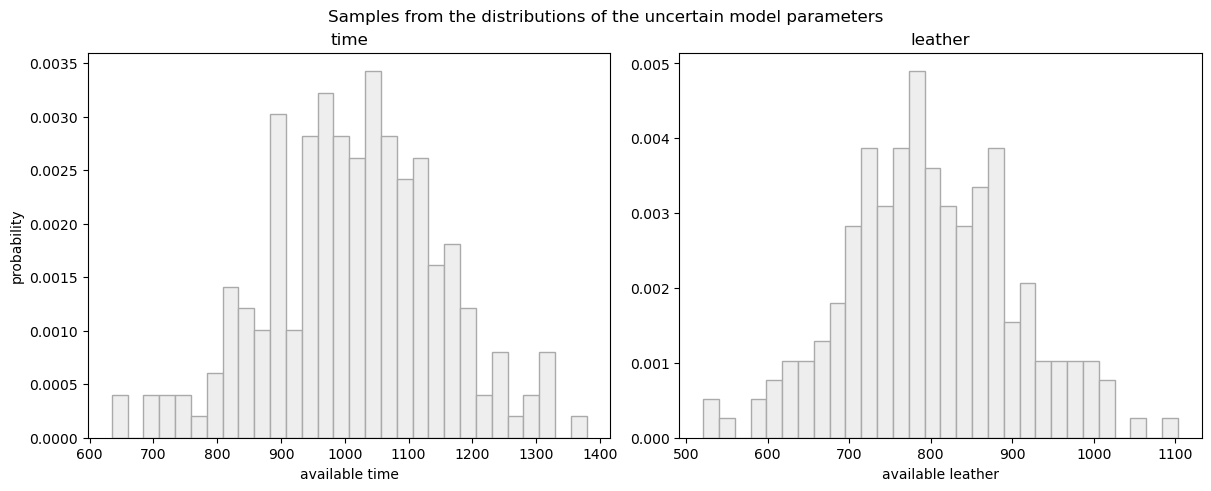

In [7]:
n_scenarios = 200
np.random.seed(seed=1)
time_available_dist = stats.norm(1000,150)
leather_available_dist = stats.norm(800,100)

samples_time_available = time_available_dist.rvs(n_scenarios)
samples_leather_available = leather_available_dist.rvs(n_scenarios)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(12, 4.8), constrained_layout=True)
fig.suptitle("Samples from the distributions of the uncertain model parameters")
ax1.set_ylabel("probability")

ax1.set_title("time")
count, bins, ignored = ax1.hist( samples_time_available , bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA")
ax1.set_xlabel("available time")

ax2.set_title("leather")
count, bins, ignored = ax2.hist( samples_leather_available , bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA")
ax2.set_xlabel("available leather")
plt.show()

## Case Study: Python Implementation of the Model Creation
Below, the creation of the mathematical is wrapped into a function that takes
- the time and leather samples
- and the solver 
as parameters



In [8]:
def build_model_with_samples(samples_time_available, samples_leather_available, solver):    
    n_scenarios = len(samples_time_available)    
    scenarios = np.arange(n_scenarios)
    #sets
    belt_types = np.arange(2)
    #deterministic parameters
    profit_contribution = [2, 1.5]
    time_consumption = [2, 1]
    bucks_available = [400, 700]

    #probability of each scenario
    prob = np.full((n_scenarios), 1.0/n_scenarios)
    alpha = 0.95
    #bigM is used for switching off constraints by adding it to the resource capacity in a scenario
    #if it is chosen as difference between the max and min capacity, it is definitely large enough to switch off the constraint
    bigM = [max(samples_time_available)-min(samples_time_available),max(samples_leather_available)-min(samples_leather_available)]
        
    m = Model(solver_name=solver)  
    production = [ m.add_var(var_type=INTEGER) for i in belt_types ] # production variable 
    is_scenario_violated =  [ m.add_var(var_type=BINARY) for s in scenarios ] # binary variable indicating if scenario is vilated or not

    m.objective =  maximize( xsum(profit_contribution[b] * production[b] for b in belt_types) ) # objective function

    for s in scenarios:
        m += sum (time_consumption[b]*production[b] for b in belt_types) <= samples_time_available[s] + bigM[0]*(is_scenario_violated[s]) # chance constraint for time
        m += sum (production[b] for b in belt_types) <= samples_leather_available[s] + bigM[1]*(is_scenario_violated[s]) # chance constraint for leather
   
    m += sum ( prob[s]*is_scenario_violated[s] for s in scenarios) <= 1-alpha   # enforcing the maximium allowed violation probability

    return m

## Let us Try the Different Solvers
- CBC

In [9]:
model_instance_cbc = build_model_with_samples(samples_time_available, samples_leather_available, solver=CBC)

start = time.time()

model_instance_cbc.optimize()

print (f'Solution time with CBC: {time.time()-start:0.2f} seconds' )

Solution time with CBC: 1.27 seconds


- Gurobi

In [10]:
model_instance_gurobi = build_model_with_samples(samples_time_available, samples_leather_available, solver=GRB)

start = time.time()

model_instance_gurobi.optimize()

print (f'Solution time with Gurobi: {time.time()-start:0.2f} seconds' )


Solution time with Gurobi: 0.14 seconds


**Question: Can we tune the (free) solver CBC to become competitive with Gurobi for this problem?**

# Algorithm Configuration Basics

## What are Parameters?

Parameters are settings of an algorithm (or solver) that change the
way an algorithm solves a problem.


## What are Parameters?


Parameters are settings of an algorithm (or solver) that change the
way an algorithm solves a problem.

### There are configurable and non-configurable parameters:



**Configurable**
- simulated annealing start temperature
- population size in a genetic algorithm (GA)
- branching heuristic in Branch-and-Bound 
- probability of a GA mutation

**Non-Configurable**
- random seed
- instance to be solved
- numerical accuracy in an exact solver
- maximum solution time


## Parameter Types


- Continuous: e.g. $[1.0, 5.0]$
- Discrete: e.g. $\{1, \dots, 10\}$
- Categorical: e.g. $\{a, b, c, d\}$
- Ordinal: e.g. $\{low, medium, high\}$ (Ordered set)



## Parameter Examples: Genetic Algorithm
A genetic algorithm could have the following parameters:


| Parameter      | Description                               |Considered values    |
|:--------------------|:-------------------------------------------|:----------------------------|
| $$\color{cyan} {\textsf{ population }}$$ | Population size    | 1..infinity                      |
| $$\color{red} {\textsf{recombProb }}$$ | Recombination probability| 0-1.0                       |
| $$\color{red} {\textsf{mutProb }}$$    |  Mutation probability          | 0-1.0                |
| $$\color{green} {\textsf{select   }}$$    | Selection heuristic             | 'Roulette', 'Tournament', 'Random'       |
| $$\color{green}{\textsf{fitness-scaling  }}$$    | Use fitness scaling?     | 'yes', 'no'              |

$$\color{cyan}{\textsf{discrete }}, \color{red}{\textsf{continuous}}, \color{green}{\textsf{categorical}}$$

## MIP Solver Parameters Used in our Case Study
In our case study, we will configure the MIP solver *CBC*
- CBC has many parameters, but we will only use a subset
- we will use the following parameters for configuration:


| Parameter      | Description                               |Considered values    |
|:--------------------|:-------------------------------------------|:----------------------------|
| $$\color{green}{\textsf{nodeStrategy}}$$    | Strategy for selecting nodes to branch on   | 'depth', 'fewest','hybrid' |
| $$\color{cyan} {\textsf{ strongBranching }}$$ | # vars. to consider in strong branching     | 0-10                       |
| $$\color{cyan} {\textsf{trustPseudoCosts }}$$ | str. br. evals before trusting pseudo costs | 0-10                       |
| $$\color{green} {\textsf{preprocess }}$$    | Switch for model preprocessing              | 'on', 'off'                |
| $$\color{green} {\textsf{presolve   }}$$    | Switch for presolve reductions              | 'on', 'off','sos'          |
| $$\color{green}{\textsf{cutsOnOff   }}$$    | Switch for cut generation (all cuts)        | 'on', 'off'                |
| $$\color{green}{\textsf{ heuristicsOnOff }}$$ | Turn (all) heuristics on/off                | 'on', 'off'             |

$$\color{cyan}{\textsf{discrete }}, \color{red}{\textsf{continuous}}, \color{green}{\textsf{categorical}}$$

## Let us Start Playing with CBC Parameters in our Case Study

- first, we write a function for setting parameters


In [11]:
def set_cbc_parameter(model_instance, parameter, value):
    cbc_set_parameter(model_instance.solver,parameter,str(value)) # the function cbc_set parameter only takes string, we thus convert numbers to strings here
  

- now, we try out the parameter 'node_strategy' to 'depth'
- observe: we first make a copy to avoid that CBC uses a *warm start*, that is, starts from the previous state

In [12]:
model_instance_cbc = model_instance_cbc.copy() # reset the model to a fresh state (to avoid warm start!)

set_cbc_parameter(model_instance_cbc, 'heuristicsOnOff','off') # as an example, let us try depth-first-search

start = time.time()
model_instance_cbc.optimize()
print (f'Solution time: {time.time()-start:0.2f} seconds' )


Solution time: 1.10 seconds


## Making Experimentation Easier: An Evaluation Function

- we write a function that takes a model instance and a set of named parameter-value pairs
- and performs the complete evaluation based on a threshold of 30 seconds (returning the PAR10-performance, that is 10\*30 in case of timeout

In [13]:
def evaluate_parameters_on_instance(model_instance, **params):

    model = model_instance.copy() # we make a copy of the model here since    
    model.seed = 42 # set the seed to make multiple runs comparable
    
    for param, value in params.items(): # iterate over the names and values of the parameters
        cbc_set_parameter(model.solver,param,str(value)) # the function cbc_set parameter takes only strings
        
    time_limit_seconds = 30 
    start = time.time()    
    status = model.optimize(max_seconds=time_limit_seconds) # we set the runtime limit to 30
    
    if status == OptimizationStatus.OPTIMAL:    
        return (time.time()-start)    
    else: #  if the limit is exceeded, we return the time_limit *10, this is the PAR10 logic   
        return time_limit_seconds * 10

- let's see this in action:

In [14]:
performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='few', heuristicsOnOff='off', preprocess='off')
print (f'Solution time: {performance:0.2f} seconds' )

performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='hybrid', heuristicsOnOff='off', 𝗌𝗍𝗋𝗈𝗇𝗀𝖡𝗋𝖺𝗇𝖼𝗁𝗂𝗇𝗀 =0.4, presolve='off', preprocess='off', 𝗍𝗋𝗎𝗌𝗍𝖯𝗌𝖾𝗎𝖽𝗈𝖢𝗈𝗌𝗍𝗌=0)
print (f'Solution time: {performance:0.2f} seconds' )

Solution time: 1.07 seconds
Solution time: 0.94 seconds


## Exercise: Play with the Parameters!

Play with the following parameters! What is your best parameter combination?

| Parameter      | Description                               |Considered values    |
|:--------------------|:-------------------------------------------|:----------------------------|
| $$\color{green}{\textsf{nodeStrategy}}$$    | Strategy for selecting nodes to branch on   | 'depth', 'fewest','hybrid' |
| $$\color{cyan} {\textsf{ strongBranching }}$$ | # vars. to consider in strong branching     | 0-10                       |
| $$\color{cyan} {\textsf{trustPseudoCosts }}$$ | str. br. evals before trusting pseudo costs | 0-10                       |
| $$\color{green} {\textsf{preprocess }}$$    | Switch for model preprocessing              | 'on', 'off'                |
| $$\color{green} {\textsf{presolve   }}$$    | Switch for presolve reductions              | 'on', 'off','sos'          |
| $$\color{green}{\textsf{cutsOnOff   }}$$    | Switch for cut generation (all cuts)        | 'on', 'off'                |
| $$\color{green}{\textsf{ heuristicsOnOff }}$$ | Turn (all) heuristics on/off                | 'on', 'off'             |

$$\color{cyan}{\textsf{discrete }}, \color{red}{\textsf{continuous}}, \color{green}{\textsf{categorical}}$$

In [15]:
performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='fewest',cutsOnOff='off', strongBranching=5)
print (f'Solution time: {performance:0.2f} seconds' )

Solution time: 0.61 seconds


## Why Bothering with Algorithm Configuration?

**Why would we care about algorithm configuration?**
- in many cases, algorithms are not only used once, but are part of a repeating planning workflow
  - e.g. monthly staff scheduling, daily power plant dispatch
- in these cases, the instance to solve are very similar
- sometimes, runtime is critical to allow testing multiple scenarios
- in many cases, configuration can lead to big runtime reductions
  - often, only a fraction (say, 1/10) of original runtime is needed
    after configuration
    

## Goals of Algorithm Configuration

There are two main types of algorithm configuration:

<div class="alert alert-block alert-info">
<b>Runtime configuration</b> <br> 
<li>Concerned with minimizing the runtime of a target algorithm.
</div>

<div class="alert alert-block alert-danger">
<b>Quality configuration</b> <br> 
<li>Concerned with minimizing an objective function seen only through the evaluation of an algorithm.
<li> This is generally the fitness/objective function of an optimization algorithm or the solution of a simulation.
</div>


## Offline Configuration and  Online Application


![off_on](img/algorithm_configuration_offline_online.png)




## Homogeneous vs Heterogeneous Instance Sets
#### Homogeneous datasets
*Homogeneous instance sets* contain instances with similar structures, allowing algorithms to use similar parameters on all of the instances to solve them.


#### Heterogeneous instance sets
*Heterogeneous instance sets* consist of two or more homogeneous sub-sets, but which instance belongs to which sub-set is unclear. Different parameter values are required for different instances.

$\rightarrow$ This case may require a combination of algorithm selection (e.g. based on clustering) and algorithm configuration!


## Manual Configuration?

Can't we just **manually** tune parameters? 

We can, but it is
- time-consuming
- error-prone and 
- tedious

In [16]:
performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='hybrid', heuristicsOnOff='off')
print (f'Solution time: {performance:0.2f} seconds' )

performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='hybrid', heuristicsOnOff='on')
print (f'Solution time: {performance:0.2f} seconds' )

performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='fewest', heuristicsOnOff='on')
print (f'Solution time: {performance:0.2f} seconds' )

Solution time: 1.06 seconds
Solution time: 1.25 seconds
Solution time: 1.22 seconds


In many cases, it is more effective to **automate** algorithm
configuration!

# Automating the Configuration of Algorithms

##  Automating the Configuration of Algorithms

The goal of the following part is to get an introduction to the topic of
**algorithm configuration**

In particular,  will discuss
- the idea and the challenges of automatic algorithm configuration
- how to use black box (Bayesian) optimization for automatic algorithm configuration
- how to address the challenge of overfitting
- how to speed up algorithm configuration by using early stopping

As in the last weeks, we will
- use a case study (see above) to illustrate the concepts learned
- provide implementations of an algorithm configuration approach for
  this case study in this Jupyter Notebook


## Automatic Algorithm Configuration: The Idea and the Challenges

## Automatic Algorithm Configuration

- automatic algorithm configurators **automatically** try different parameter settings on selected instances and measure the performance of the target algorithm. 
- they perform the search in a somewhat intelligent way

![off_on](img/automatic_algorithm_configuration.png)


## Challenges

#### Automated algorithm configurators have to overcome the following challenges (among many others):
- Which instances to evaluate parameterizations on
- Which parameterizations to test
- Testing parameterizations is **expensive**
- Big risk of overfitting

#### Why is algorithm configuration different from other optimization problems?
- The objective function in most metaheuristics is easy to evaluate (that is: fast)

-  Algorithm configurators must execute the target algorithm with a parameterization **on multiple instances** to evaluate it.

## Addressing the Challenges of Algorithm Configuration: Case Study


In the remainder of this meeting, we will see how we can address some of
the challenges using "standard" tools in our case study:



- using **Bayesian Optimization** to search the space of configurations
- optimize using **multiple training instances** to avoid overfitting
- use a simple **early stopping strategy** to reduce the time spent evaluating bad configurations


# Using Black Box (Bayesian) Optimization for Algorithm Configuration

## Black Box Optimization using Bayesian Optimization

A **black box optimizer** treats the optimization problem as "black box"
- it does not make any assumption regarding problem structure (e.g. linearity)
- it only requires a mechanism that returns the value of a solution / configuration

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-0.png)

Source: https://distill.pub/2020/bayesian-optimization/

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-1.png)

Source: https://distill.pub/2020/bayesian-optimization/

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-2.png)

Source: https://distill.pub/2020/bayesian-optimization/

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-3.png)

Source: https://distill.pub/2020/bayesian-optimization/

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-4.png)

Source: https://distill.pub/2020/bayesian-optimization/

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-5.png)
Source: https://distill.pub/2020/bayesian-optimization/

## Optuna: A Package for Black Box/Hyperparameter Optimization

A **black box optimizer** treats the optimization problem as "black box"
- it does not make any assumption regarding problem structure (e.g. linearity)
- it only requires a mechanism that returns the value of a solution / configuration



**Optuna** https://optuna.org/
- is a package for black box / hyperparameter optimization with different methods, in particular:
  - Grid Search 
  - **Bayesian Optimization** with Gaussian Processes
  - tree-based sampling
- it can also be used for hyperparameter tuning of machine learning models

..there are similar packages such as scikit-optimize (not developed any longer)

## Recall: MIP Solver Parameters Used in our Case Study
In our case study, we will configure the MIP solver *CBC*
- CBC has many parameters, but we will only use a subset
- we will use the following parameters for configuration:


| Parameter      | Description                               |Considered values    |
|:--------------------|:-------------------------------------------|:----------------------------|
| $$\color{green}{\textsf{nodeStrategy}}$$    | Strategy for selecting nodes to branch on   | 'depth', 'fewest','hybrid' |
| $$\color{cyan} {\textsf{ strongBranching }}$$ | # vars. to consider in strong branching     | 0-10                       |
| $$\color{cyan} {\textsf{trustPseudoCosts }}$$ | str. br. evals before trusting pseudo costs | 0-10                       |
| $$\color{green} {\textsf{preprocess }}$$    | Switch for model preprocessing              | 'on', 'off'                |
| $$\color{green} {\textsf{presolve   }}$$    | Switch for presolve reductions              | 'on', 'off','sos'          |
| $$\color{green}{\textsf{cutsOnOff   }}$$    | Switch for cut generation (all cuts)        | 'on', 'off'                |
| $$\color{green}{\textsf{ heuristicsOnOff }}$$ | Turn (all) heuristics on/off                | 'on', 'off'             |

$$\color{cyan}{\textsf{discrete }}, \color{red}{\textsf{continuous}}, \color{green}{\textsf{categorical}}$$

## Defining the Parameter Space and the Evaluation Function

In Optuna, we have to define an evaluation function (objective function) that
- has an argument "trial" that refers to a certain parameter configuration
- includes some lines of code that make optuna choose the next parameters (this **implicitly defines the parameter space**), e.g.
  - `trial.suggest_categorical` for categorical parameters
- runs the parameterized code that is to be evaluated (e.g. solving an optimization model, training an ML model)
- returns a performance metric (e.g. runtime of an algorithm, accuracy of the fitted ML model)



In [17]:
import optuna

model_instance_for_objective = model_instance_cbc

def performance_objective_single_instance(trial): # we always need the trial parameter

    node_strategy = trial.suggest_categorical('nodeStrategy', ['hybrid','fewest','depth'])
    strong_branching = trial.suggest_int('strongBranching',0,10)
    trust_pseudo_costs = trial.suggest_int('trustPseudoCosts',0,10)    
    preprocess = trial.suggest_categorical('preprocess', ['on','off'])
    presolve = trial.suggest_categorical('presolve', ['on','off'])
    cuts_on_off = trial.suggest_categorical('cutsOnOff', ['on','off'])
    heuristics_on_off = trial.suggest_categorical('heuristicsOnOff', ['on','off'])
    
    
    return evaluate_parameters_on_instance(model_instance_for_objective,**trial.params)
    

## Running the Optimization
- let us now run the optimization
- note that by using the parameter `n_calls`, we limit the number of configurations evaluated to 50

In [18]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler()) # this sampler works with all sorts of parameters

study.optimize(performance_objective_single_instance, n_trials=50)

[I 2025-07-15 10:10:27,338] A new study created in memory with name: no-name-0ca81837-dd7f-4403-8d55-fc516d50243c
[I 2025-07-15 10:10:28,835] Trial 0 finished with value: 1.481778621673584 and parameters: {'nodeStrategy': 'hybrid', 'strongBranching': 5, 'trustPseudoCosts': 3, 'preprocess': 'off', 'presolve': 'off', 'cutsOnOff': 'on', 'heuristicsOnOff': 'off'}. Best is trial 0 with value: 1.481778621673584.
[I 2025-07-15 10:10:30,420] Trial 1 finished with value: 1.5745337009429932 and parameters: {'nodeStrategy': 'fewest', 'strongBranching': 1, 'trustPseudoCosts': 1, 'preprocess': 'off', 'presolve': 'on', 'cutsOnOff': 'on', 'heuristicsOnOff': 'on'}. Best is trial 0 with value: 1.481778621673584.
[I 2025-07-15 10:10:31,025] Trial 2 finished with value: 0.5944304466247559 and parameters: {'nodeStrategy': 'fewest', 'strongBranching': 4, 'trustPseudoCosts': 5, 'preprocess': 'on', 'presolve': 'on', 'cutsOnOff': 'off', 'heuristicsOnOff': 'on'}. Best is trial 2 with value: 0.5944304466247559.

[I 2025-07-15 10:10:47,402] Trial 28 finished with value: 0.40650033950805664 and parameters: {'nodeStrategy': 'depth', 'strongBranching': 4, 'trustPseudoCosts': 3, 'preprocess': 'off', 'presolve': 'off', 'cutsOnOff': 'off', 'heuristicsOnOff': 'off'}. Best is trial 27 with value: 0.21621417999267578.
[I 2025-07-15 10:10:47,713] Trial 29 finished with value: 0.2952582836151123 and parameters: {'nodeStrategy': 'depth', 'strongBranching': 2, 'trustPseudoCosts': 2, 'preprocess': 'off', 'presolve': 'off', 'cutsOnOff': 'off', 'heuristicsOnOff': 'off'}. Best is trial 27 with value: 0.21621417999267578.
[I 2025-07-15 10:10:47,967] Trial 30 finished with value: 0.21854543685913086 and parameters: {'nodeStrategy': 'depth', 'strongBranching': 5, 'trustPseudoCosts': 1, 'preprocess': 'off', 'presolve': 'off', 'cutsOnOff': 'off', 'heuristicsOnOff': 'off'}. Best is trial 27 with value: 0.21621417999267578.
[I 2025-07-15 10:10:48,214] Trial 31 finished with value: 0.23183798789978027 and parameters: {

In [19]:
print(f"Best configuration: {study.best_params}")
print(f"Best performance in seconds: {study.best_value:0.2f}")
study_single_instance = study

Best configuration: {'nodeStrategy': 'depth', 'strongBranching': 4, 'trustPseudoCosts': 1, 'preprocess': 'off', 'presolve': 'off', 'cutsOnOff': 'off', 'heuristicsOnOff': 'off'}
Best performance in seconds: 0.22


## Print more pretty as Data Frame

In [20]:
pd.DataFrame({k: [v] for k, v in study.best_params.items()})

,nodeStrategy,strongBranching,trustPseudoCosts,preprocess,presolve,cutsOnOff,heuristicsOnOff
0,depth,4,1,off,off,off,off


## Showing all Evaluations

- we can create a data frame with all evaluations:

In [21]:
df_trials = study.trials_dataframe()
df_trials

,number,value,datetime_start,datetime_complete,duration,params_cutsOnOff,params_heuristicsOnOff,params_nodeStrategy,params_preprocess,params_presolve,params_strongBranching,params_trustPseudoCosts,state
0,0,1.481779,2025-07-15 10:10:27.338509,2025-07-15 10:10:28.835911,0 days 00:00:01.497402,on,off,hybrid,off,off,5,3,COMPLETE
1,1,1.574534,2025-07-15 10:10:28.835911,2025-07-15 10:10:30.420494,0 days 00:00:01.584583,on,on,fewest,off,on,1,1,COMPLETE
2,2,0.594430,2025-07-15 10:10:30.422536,2025-07-15 10:10:31.025027,0 days 00:00:00.602491,off,on,fewest,on,on,4,5,COMPLETE
3,3,1.328962,2025-07-15 10:10:31.025027,2025-07-15 10:10:32.363994,0 days 00:00:01.338967,on,off,hybrid,off,on,1,9,COMPLETE
4,4,1.178860,2025-07-15 10:10:32.363994,2025-07-15 10:10:33.558475,0 days 00:00:01.194481,on,off,depth,off,on,0,1,COMPLETE
5,5,0.284957,2025-07-15 10:10:33.558475,2025-07-15 10:10:33.859054,0 days 00:00:00.300579,off,off,hybrid,off,on,1,7,COMPLETE
6,6,1.313071,2025-07-15 10:10:33.859054,2025-07-15 10:10:35.187749,0 days 00:00:01.328695,on,off,hybrid,on,on,9,8,COMPLETE
7,7,1.228616,2025-07-15 10:10:35.187749,2025-07-15 10:10:36.431987,0 days 00:00:01.244238,on,off,hybrid,off,off,1,4,COMPLETE
8,8,2.107815,2025-07-15 10:10:36.431987,2025-07-15 10:10:38.561437,0 days 00:00:02.129450,on,on,depth,off,on,1,2,COMPLETE
9,9,1.267193,2025-07-15 10:10:38.562434,2025-07-15 10:10:39.843590,0 days 00:00:01.281156,on,off,fewest,on,on,3,6,COMPLETE


- we can then even filter these results, e.g. to show all runs taking less than one second:

In [22]:
df_trials[df_trials["value"] <= 0.25]

,number,value,datetime_start,datetime_complete,duration,params_cutsOnOff,params_heuristicsOnOff,params_nodeStrategy,params_preprocess,params_presolve,params_strongBranching,params_trustPseudoCosts,state
17,17,0.249519,2025-07-15 10:10:43.805327,2025-07-15 10:10:44.070469,0 days 00:00:00.265142,off,off,depth,off,off,6,0,COMPLETE
22,22,0.232342,2025-07-15 10:10:45.353013,2025-07-15 10:10:45.606463,0 days 00:00:00.253450,off,off,depth,off,off,6,1,COMPLETE
23,23,0.219121,2025-07-15 10:10:45.607545,2025-07-15 10:10:45.847490,0 days 00:00:00.239945,off,off,depth,off,off,5,1,COMPLETE
25,25,0.226207,2025-07-15 10:10:46.160895,2025-07-15 10:10:46.410890,0 days 00:00:00.249995,off,off,depth,off,off,4,1,COMPLETE
27,27,0.216214,2025-07-15 10:10:46.748871,2025-07-15 10:10:46.980739,0 days 00:00:00.231868,off,off,depth,off,off,4,1,COMPLETE
30,30,0.218545,2025-07-15 10:10:47.713710,2025-07-15 10:10:47.967121,0 days 00:00:00.253411,off,off,depth,off,off,5,1,COMPLETE
31,31,0.231838,2025-07-15 10:10:47.967121,2025-07-15 10:10:48.214555,0 days 00:00:00.247434,off,off,depth,off,off,5,1,COMPLETE
32,32,0.227628,2025-07-15 10:10:48.214555,2025-07-15 10:10:48.457778,0 days 00:00:00.243223,off,off,depth,off,off,4,1,COMPLETE
35,35,0.219332,2025-07-15 10:10:49.185385,2025-07-15 10:10:49.435961,0 days 00:00:00.250576,off,off,depth,off,off,5,1,COMPLETE
42,42,0.237868,2025-07-15 10:10:53.556068,2025-07-15 10:10:53.820523,0 days 00:00:00.264455,off,off,depth,off,off,5,0,COMPLETE


## Printing the Progress



In [23]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

# Avoiding Overfitting

## Avoiding Overfitting

- even in case of homogeneous instances, algorithm configuration is
  very prone to overfitting


- in general, in machine learning, we would use cross validation for addressing overfitting
- in algorithm configuration, however, **cross validation is not
  practical** since it requires too many time-consuming evaluations
- thus, in algorithm configuration one mostly uses 
  - a single training set
  - and a single test set


## Evaluating the Configuration on a Test Set

Let us see how our configuration (selected for a single instance) performs on average for a test set of 10 instances

**Question:**
- How can we create a test set (a set of test instances) for our CCP case study?


In [24]:
np.random.seed(seed=11)
number_of_test_instances = 10
test_instances =  [ build_model_with_samples( time_available_dist.rvs(n_scenarios), leather_available_dist.rvs(n_scenarios), CBC) 
                    for i in range(number_of_test_instances) ]

- then, we define an evaluation function for evaluating a configuration on a **single** instance:

In [25]:
def evaluate_best_parameters_on_instance(instance, study):    
    return evaluate_parameters_on_instance(instance, **study.best_params)    

evaluate_best_parameters_on_instance(model_instance_cbc, study)

0.23774957656860352

- then, we define an evaluation function for evaluating a configuration on **multiple** instances:

In [26]:
def evaluate_parameters_on_instances(instances, **params):
    total_time = 0    
    number_of_instances = len(instances)    
    for instance in instances:
        total_time += evaluate_parameters_on_instance(instance, **params)        
    return total_time / number_of_instances


- and another function that directly takes the configuration obtained wie `scikit-optimize` and applies it to a set of instances:

In [27]:
def evaluate_best_parameters_on_instances(instances, study):    
    return evaluate_parameters_on_instances(instances, **study.best_params)                                            

## Evaluating the Configuration on a Test Set: Results

Let's create a data frame to collect the results

In [28]:
df_results = pd.DataFrame(columns=['train_perf','test_perf'])

- we start with an evaluation of the CBC standard settings:

In [29]:
df_results.loc['Standard CBC','test_perf'] = evaluate_parameters_on_instances(test_instances)

- and then add those from training with a single instance (note: train performance is based on a single instance, test performance is evaluated using 10 instances

In [32]:
df_results.loc['Configured Single Instance','train_perf'] = study_single_instance.best_value

df_results.loc['Configured Single Instance','test_perf']=  evaluate_best_parameters_on_instances(test_instances,study_single_instance)

In [33]:
df_results

,train_perf,test_perf
Standard CBC,NaN,1.356098
Configured Single Instance,0.216214,0.235957


## Addressing Overfitting: Configuration using Multiple Training Instances

Let us see if we can do better by evaluating each configuration on multiple instances **during training**!
- ..of course, these instances should be different from the test set!
- we thus create 10 training instances:

In [34]:
np.random.seed(seed=42) ## attention: different random seed!
number_of_training_instances = 10
training_instances =  [ build_model_with_samples( time_available_dist.rvs(n_scenarios), leather_available_dist.rvs(n_scenarios), CBC) 
                        for i in range(number_of_training_instances) ]

- then, we create an objective function for scikit-optimize that uses these 10 instances:
    

In [35]:
instances_to_evaluate = training_instances  

def performance_objective_multiple_instances(trial): # we always need the trial parameter

    node_strategy = trial.suggest_categorical('nodeStrategy', ['hybrid','fewest','depth'])
    strong_branching = trial.suggest_int('strongBranching',0,10)
    trust_pseudo_costs = trial.suggest_int('trustPseudoCosts',0,10)    
    preprocess = trial.suggest_categorical('preprocess', ['on','off'])
    presolve = trial.suggest_categorical('presolve', ['on','off'])
    cuts_on_off = trial.suggest_categorical('cutsOnOff', ['on','off'])
    heuristics_on_off = trial.suggest_categorical('heuristicsOnOff', ['on','off'])
    
    
    return evaluate_parameters_on_instances(instances_to_evaluate, **trial.params)

## Automatic Configuration Using Multiple Instances

In [ ]:
start_time_configuration_multiple_instances = time.time()

study_multiple_instances =  optuna.create_study(sampler=optuna.samplers.TPESampler()) # this sampler works with all sorts of parameters

study_multiple_instances.optimize(performance_objective_multiple_instances, n_trials=50)

duration_configuration_multiple_instances = time.time() - start_time_configuration_multiple_instances

print (f"The configuration took {duration_configuration_multiple_instances:0.2f} seconds")

## Automatic Configuration Using Multiple Instances: Results

How did it work?

In [ ]:
df_results.loc['Configured Multiple Instances','train_perf'] = study_multiple_instances.best_value

df_results.loc['Configured Multiple Instances','test_perf']=  evaluate_best_parameters_on_instances(test_instances, study_multiple_instances )

df_results

- it worked better, that is, using multiple training instances is advantageous.

# Making Algorithm Configuration Faster: Early Stopping

## Making Configuration Faster: Early Stopping

**Challenge: Long Configuration Time**

**Long configuration times**
- using multiple training instances will improve the robustness of the results, 
- but it will also drastically increase configuration time


**Question:** Do you have any idea how to reduce configuration time?


**We can reduce configuration time by**
- quickly recognizing bad configurations and evaluating them on only a
  few instances
- we may even use statistical tests to detect bad configurations early
- in our case study, we will use Optuna's **pruning** functinality

## Early Stopping / Pruning with Optuna

Optuna offers out-of the box functionality for pruning.

**To use pruning, we need to**:
- select a pruning rule (e.g. Median pruning)
- report intermediate results after each step (in our case: after each instance)
- call the function `should_prune` to  let Optuna apply the pruning rule to decide whether to early stop a trial or not.

**Example pruning rule: Median Pruning**


Prune if 
- the trial’s best intermediate result is worse than median of intermediate results of previous trials at the same step
- It stops unpromising trials early based on the intermediate results compared against the median of previous completed trials.

## Early Stopping / Pruning with Optuna: Implementation 

In [ ]:
def performance_objective_multiple_instances_early_stopping(trial):

    node_strategy = trial.suggest_categorical('nodeStrategy', ['hybrid','fewest','depth'])
    strong_branching = trial.suggest_int('strongBranching',0,10)
    trust_pseudo_costs = trial.suggest_int('trustPseudoCosts',0,10)    
    preprocess = trial.suggest_categorical('preprocess', ['on','off'])
    presolve = trial.suggest_categorical('presolve', ['on','off'])
    cuts_on_off = trial.suggest_categorical('cutsOnOff', ['on','off'])
    heuristics_on_off = trial.suggest_categorical('heuristicsOnOff', ['on','off'])
    
    
    for step, instance in enumerate(instances_to_evaluate):
        
        evaluated_instances = step + 1
  
        total_performance += evaluate_parameters_on_instance(instance, **trial.params)
    
        # compute average performance so far
        average_performance = total_performance / evaluated_instances  
        
        #report to the pruner
        trial.report(average_performance, step)

          # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()
            
    return average_performance    

##  Running the Algorithm Configuration with the Early Stopping Approach

- now, we run the early stopping-based algorithm configuration 
- the following implementation uses the sickit-optimizes ask-and-tell interface explained above

In [ ]:

number_of_total_iterations = 50


start_time_early_stopping = time.time()

study_multiple_instances_pruning =  optuna.create_study(sampler=optuna.samplers.TPESampler(), pruner = optuna.pruners.MedianPruner) # this sampler works with all sorts of parameters

study_multiple_instances_pruning.optimize(performance_objective_multiple_instances_early_stopping, n_trials=50)


duration_early_stopping = time.time() - start_time_early_stopping

print (f"The configuration using early stopping took {duration_early_stopping:0.2f} seconds")



## Let us see the results

- let's add the results from the early stopping approach

In [ ]:
#add to results
df_results.loc['Configured Multi Instance Early Stop','train_perf'] = study_multiple_instances_pruning.best_value

df_results.loc['Configured Multi Instance Early Stop','test_perf']=  evaluate_best_parameters_on_instances(test_instances, study_multiple_instances_pruning )



df_results

In [ ]:
df_results

..we can see that the early stopping was much faster, but we obtained similar (even better) results.

## Conclusions

**In this meeting, we dealt with algorithm configuration**
- we learned about the key concepts of algorithm configuration
- and learned how to address the key challenges in automatic algorithm configuration

**This was the last meeting of our course!**
- thank you very much for your active participation!